In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
df = pd.read_csv('data/obesity_data_cleaned.csv')
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,1,24.0,1.70,81.67,1,1,2.000000,2.983297,1,2.763573,0.000000,0.976473,1,0,0,0,1,0,6
1,0,18.0,1.56,57.00,1,1,2.000000,3.000000,2,2.000000,1.000000,1.000000,0,1,0,0,0,0,1
2,0,18.0,1.71,50.17,1,1,1.880534,1.411685,1,1.910378,0.866045,1.673584,0,0,0,0,1,0,0
3,0,20.0,1.71,131.27,1,1,3.000000,3.000000,1,1.674061,1.467863,0.780199,1,0,0,0,1,0,4
4,1,31.0,1.91,93.80,1,1,2.679664,1.971472,1,1.979848,1.967973,0.931721,1,0,0,0,1,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,1,25.0,1.77,114.19,1,1,2.919584,3.000000,1,2.151809,1.330519,0.196680,1,0,0,0,1,0,3
20754,1,18.0,1.71,50.00,0,1,3.000000,4.000000,2,1.000000,2.000000,1.000000,1,0,0,0,1,0,0
20755,1,20.0,1.82,105.58,1,1,2.407817,3.000000,1,2.000000,1.158040,1.198439,0,0,0,0,1,0,3
20756,1,33.0,1.70,83.52,1,1,2.671238,1.971472,1,2.144838,0.000000,0.973834,0,1,0,0,0,0,6


In [46]:
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Chuẩn hóa dữ liệu bằng Standard Scaler

In [47]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_scaled_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1.004152,0.077086,-0.000969,-0.235711,0.469099,0.30588,-0.836279,0.314684,-0.337845,1.206594,-1.171141,0.597438,0.471288,-0.452967,-0.039293,-0.042825,0.493925,-0.151707
1,-0.995866,-0.988500,-1.600728,-1.170931,0.469099,0.30588,-0.836279,0.338364,1.889204,-0.048349,0.021775,0.636513,-1.639846,2.207668,-0.039293,-0.042825,-2.024597,-0.151707
2,-0.995866,-0.988500,0.113300,-1.429851,0.469099,0.30588,-1.060332,-1.913423,-0.337845,-0.195644,-0.138022,1.755239,-1.639846,-0.452967,-0.039293,-0.042825,0.493925,-0.151707
3,-0.995866,-0.633304,0.113300,1.644587,0.469099,0.30588,1.039171,0.338364,-0.337845,-0.584035,0.579896,0.271455,0.471288,-0.452967,-0.039293,-0.042825,0.493925,-0.151707
4,1.004152,1.320270,2.398670,0.224128,0.469099,0.30588,0.438397,-1.119801,-0.337845,-0.081469,1.176486,0.523111,0.471288,-0.452967,-0.039293,-0.042825,0.493925,-0.151707


#  PCA và trực quan 

## Lượng phương sai giải thích theo số chiều PCA

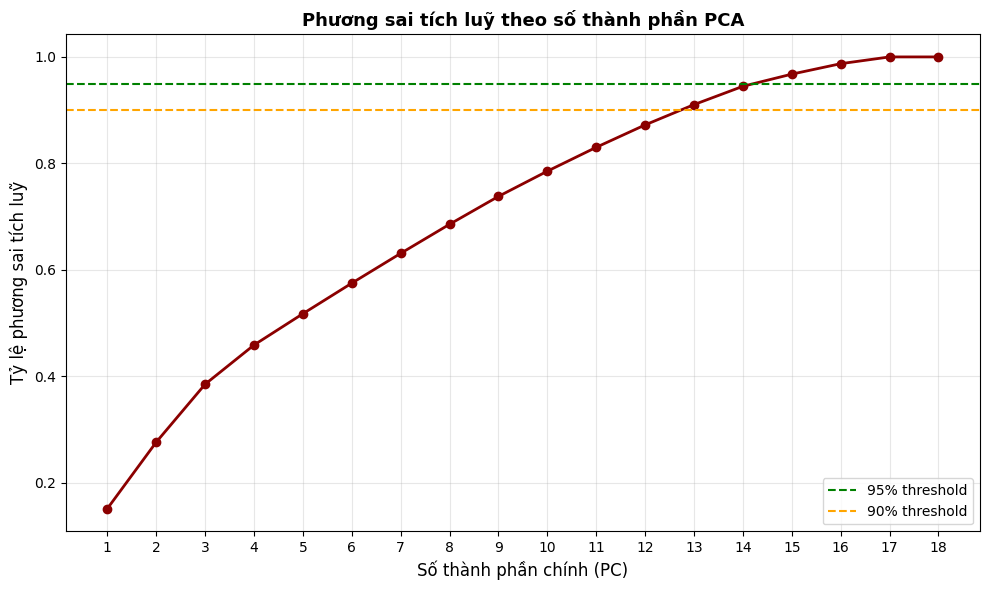

In [48]:
pca_full = PCA()
pca_full.fit(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
        marker='o', linewidth=2, markersize=6, color='darkred')
ax.axhline(y=0.95, color='green', linestyle='--', linewidth=1.5, label='95% threshold')
ax.axhline(y=0.90, color='orange', linestyle='--', linewidth=1.5, label='90% threshold')
ax.set_xlabel('Số thành phần chính (PC)', fontsize=12)
ax.set_ylabel('Tỷ lệ phương sai tích luỹ', fontsize=12)
ax.set_title('Phương sai tích luỹ theo số thành phần PCA', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xticks(range(1, len(cumulative_variance) + 1))
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

## Giảm chiều PCA về 8 chiều

In [49]:
# PCA về 8 chiều
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

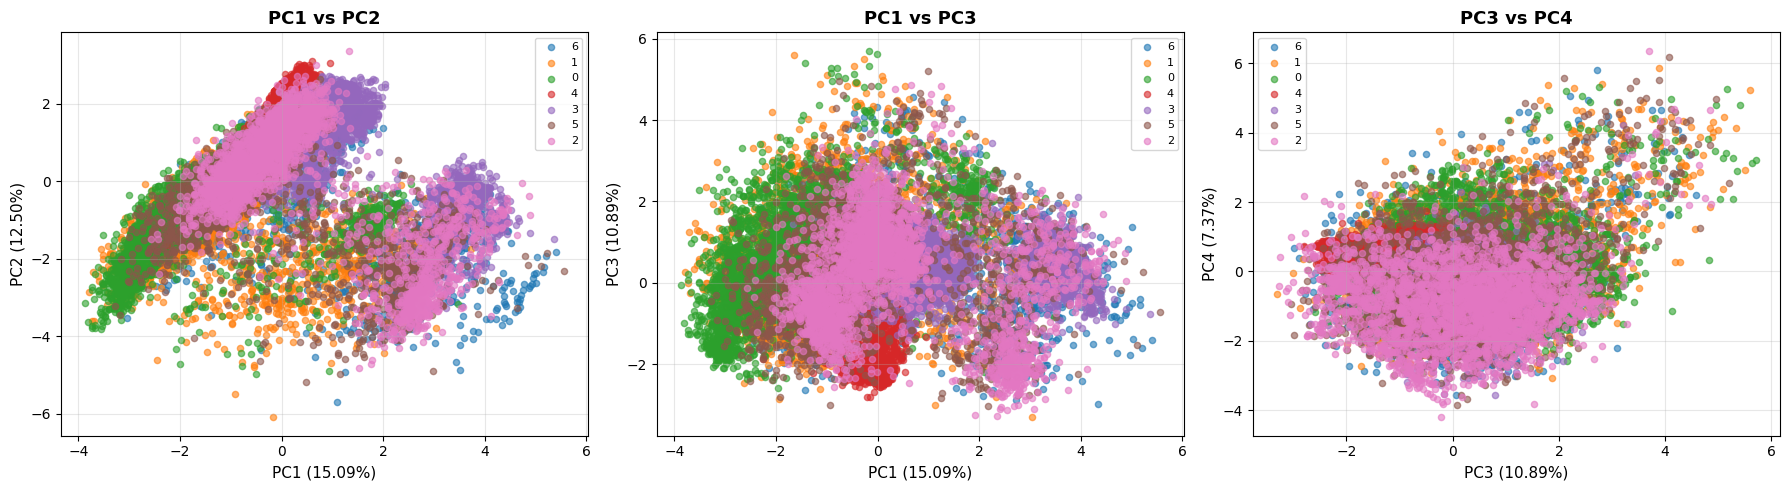

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs = [(0, 1), (0, 2), (2, 3)]
pair_names = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC3', 'PC4')]

for idx, (i, j) in enumerate(pairs):
    for label in y.unique():
        mask = y == label
        axes[idx].scatter(
            X_pca[mask, i], 
            X_pca[mask, j], 
            label=label,
            alpha=0.6, 
            s=20
        )
    axes[idx].set_xlabel(f'{pair_names[idx][0]} ({pca.explained_variance_ratio_[i]:.2%})', fontsize=11)
    axes[idx].set_ylabel(f'{pair_names[idx][1]} ({pca.explained_variance_ratio_[j]:.2%})', fontsize=11)
    axes[idx].set_title(f'{pair_names[idx][0]} vs {pair_names[idx][1]}', fontsize=13, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

In [51]:
print("Tổng phương sai giải thích bởi 4 thành phần chính:")
print(f"{pca.explained_variance_ratio_.sum():.2%}")
print("\nPhương sai giải thích bởi từng thành phần:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.2%}")

Tổng phương sai giải thích bởi 4 thành phần chính:
68.54%

Phương sai giải thích bởi từng thành phần:
PC1: 15.09%
PC2: 12.50%
PC3: 10.89%
PC4: 7.37%
PC5: 5.88%
PC6: 5.74%
PC7: 5.60%
PC8: 5.47%


# LDA và trực quan

## Lượng phương sai giải thích theo số chiều LDA

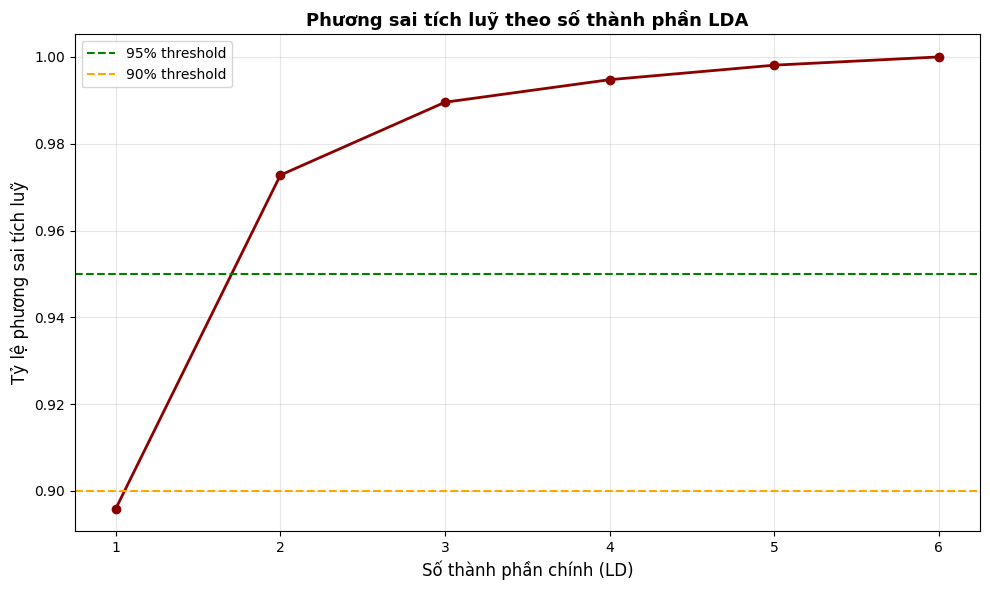

In [52]:
lda_full = LDA()
lda_full.fit(X_scaled, y)

explained_variance = lda_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
        marker='o', linewidth=2, markersize=6, color='darkred')
ax.axhline(y=0.95, color='green', linestyle='--', linewidth=1.5, label='95% threshold')
ax.axhline(y=0.90, color='orange', linestyle='--', linewidth=1.5, label='90% threshold')
ax.set_xlabel('Số thành phần chính (LD)', fontsize=12)
ax.set_ylabel('Tỷ lệ phương sai tích luỹ', fontsize=12)
ax.set_title('Phương sai tích luỹ theo số thành phần LDA', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xticks(range(1, len(cumulative_variance) + 1))
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

## Giảm chiều bằng LDA về 4 chiều

In [53]:
# LDA về 4 chiều
lda = LDA(n_components=4)
X_lda = lda.fit_transform(X_scaled, y)

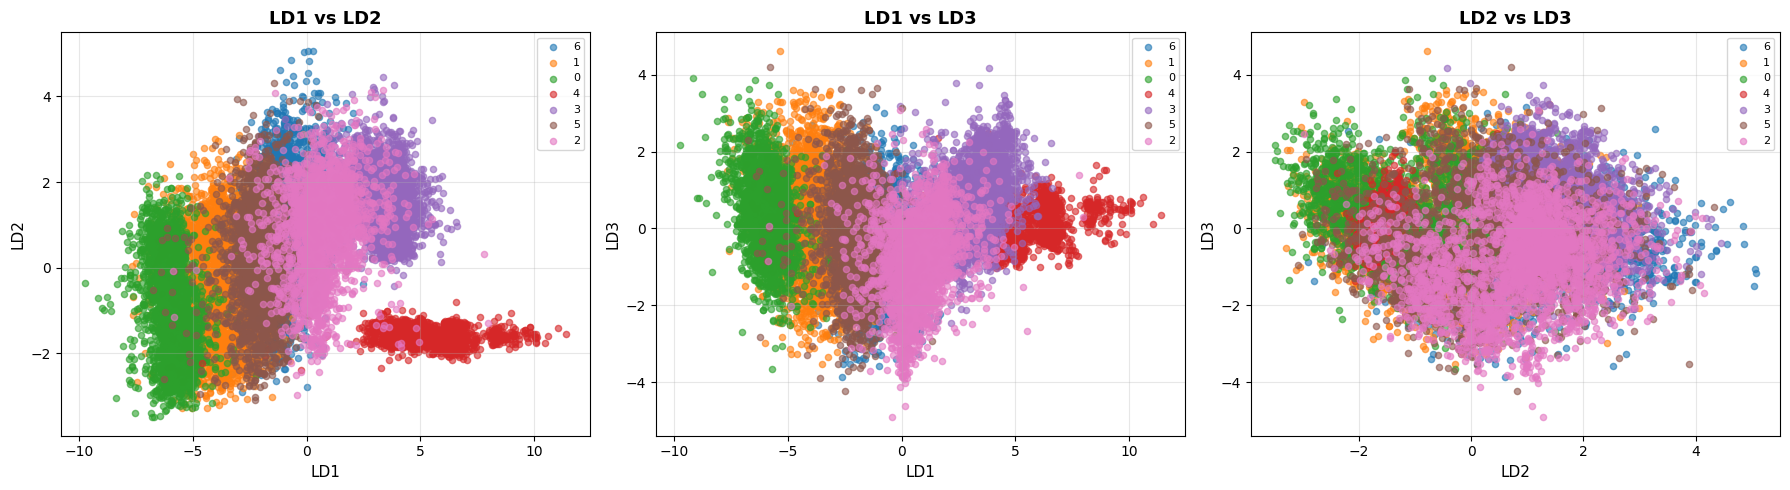

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs = [(0, 1), (0, 2), (1, 2)]
pair_names = [('LD1', 'LD2'), ('LD1', 'LD3'), ('LD2', 'LD3')]

for idx, (i, j) in enumerate(pairs):
    for label in y.unique():
        mask = y == label
        axes[idx].scatter(
            X_lda[mask, i], 
            X_lda[mask, j], 
            label=label,
            alpha=0.6, 
            s=20
        )
    axes[idx].set_xlabel(f'{pair_names[idx][0]}', fontsize=11)
    axes[idx].set_ylabel(f'{pair_names[idx][1]}', fontsize=11)
    axes[idx].set_title(f'{pair_names[idx][0]} vs {pair_names[idx][1]}', fontsize=13, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

In [55]:
print("Tỷ lệ phương sai giải thích bởi từng thành phần LDA:")
for i, var in enumerate(lda.explained_variance_ratio_):
    print(f"LD{i+1}: {var:.2%}")
print(f"\nTổng: {lda.explained_variance_ratio_.sum():.2%}")

Tỷ lệ phương sai giải thích bởi từng thành phần LDA:
LD1: 89.59%
LD2: 7.69%
LD3: 1.68%
LD4: 0.52%

Tổng: 99.48%
